In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn import manifold, preprocessing
import warnings

In [2]:
def fix_label(rels):
    rels = [s.replace(' – ',' and ') for s in rels]
    rels = [s.replace('-',' and ') for s in rels]
    rels = [s.replace(' 鈥?',' and ') for s in rels]
    rels = [s.strip() for s in rels]     
    
    rels = [s.replace("Man鈥檚 Wife and Man鈥檚 Mistress",'Man Wife and Man Mistress') for s in rels]
    rels = [s.replace('  and  ',' and ') for s in rels]
    rels = [s.replace('in and laws','in-laws') for s in rels]
    rels = [s.replace('Step and ','Step-')for s in rels]
    rels = [s.replace('Club Member and  Club President','Club Member and Club President')for s in rels]
    rels = [s.replace('Foreman and  Laborer','Foreman and Laborer')for s in rels]
    rels = [s.replace('Godparent and  Godchild','Godparent and Godchild')for s in rels]
    rels = [s.replace('Groom and  Groomsman','Groom and Groomsman')for s in rels]
    rels = [s.replace('Judge  and Lawyer','Judge and Lawyer')for s in rels]
    rels = [s.replace('Step-grandparent and  Step-grandchild','Step-grandparent and Step-grandchild')for s in rels]
    rels = [s.replace('step and ','step-')for s in rels]
    rels = [s.replace('Foster and ','Foster-')for s in rels]
    rels = [s.replace('Sugar and ','Sugar-')for s in rels]
    rels = [s.replace('Co and ','Co-')for s in rels]
    rels = [s.replace('ex and ','ex-')for s in rels]
    rels = [s.replace('pen and ','pen-')for s in rels]
    rels = [s.replace('life and ','life-')for s in rels]
    rels = [s.replace('soul and ','soul-')for s in rels]
    rels = [s.replace('half and ','half-')for s in rels]
    rels = [s.replace('long and distance','long-distance')for s in rels]
    rels = [s.replace('brothers and in and arms','brothers-in-arms')for s in rels]
    
    return rels

In [3]:
def NLP_to_Trans(rels):
    #fix the basic form of label
    rels = fix_label(rels)
    
    #one_to_one
    rels = [s.replace('Supervisor and Graduate student','Mentor and Mentee') for s in rels]
    rels = [s.replace('Between lovers','Between romantic lovers') for s in rels]

    #one_to_two
    rels = [s.replace('Between woman and in-laws','Between a person and their in-laws') for s in rels]
    rels = [s.replace('Between biao cousins','Between cousins') for s in rels]
    rels = [s.replace('Grandparent(father) and Grandchild','Grandparent and Grandchild') for s in rels]
    #'Master-Servant' doesn't need to be changed

    #two_to_two
    rels = [s.replace('Uncle/Aunt and Niece/Nephew1','Aunt and Niece/Nephew') for s in rels]
    rels = [s.replace('Uncle/Aunt and Niece/Nephew','Uncle and Niece/Nephew') for s in rels]

    return rels

# Clean and combine data

In [4]:
warnings.filterwarnings('ignore')
# Grab the qualtrics output
qual_output = '../input_data/Nations/CHN/NLP/Merge_210928.csv'

# Prep responses and key
raw = pd.read_csv(qual_output)
raw_reorg = raw.drop(axis='index',index=[0,1])
raw_reorg['subject'] = list(raw_reorg.index)
raw_reorg = raw_reorg.reset_index(drop=True)
raw_reorg['Duration (in seconds)'] = pd.to_numeric(raw_reorg['Duration (in seconds)'])
key = pd.read_csv('../input_data/Nations/CHN/NLP/qualtrics_question_key.csv')

responses = raw_reorg
responses['subject'] = list(raw_reorg.index)
responses = responses.loc[:, responses.columns.str.startswith('Q')]
responses = responses[responses.columns[1:-7]]

# Get total number of responses
print("Total number of responses from qualtrics - "+str(len(responses)))

Total number of responses from qualtrics - 6128


In [5]:
relationships_trans_258 = pd.read_csv('../input_data/Nations/CHN/NLP/Total_Relation_6_trans.csv', 
                                  header=None).iloc[:,0].tolist()
relationships = NLP_to_Trans(relationships_trans_258)

dimensions = key['dimension'].tolist()[2:-3]
dimensions = [i.replace('Importance for individuals involved','Importance for individuals') for i in dimensions]
dimensions = [i.replace('/','_') for i in dimensions]

dimension_frames = {}
count=2
for dim in dimensions:  # exclude foil and demographics
    filtered_cols = [col for col in raw_reorg if col.startswith('Q'+str(key['block'].iloc[count])+'.2')]
    dimension_frames[dim] = pd.DataFrame(responses[filtered_cols])
    dimension_frames[dim].columns = relationships
    count=count+1

print("Total number of relationships - " + str(len(dimension_frames[dim].columns)))
print("Total number of dimensions - " + str(len(dimensions)))

# Check total number of responses for each word
num_response = pd.DataFrame(columns=dimensions)
for dim in dimensions:
    num_response[dim] = dimension_frames[dim].count() 
print("Total number of responses, including all participants - "+str(len(dimension_frames[dim])))
print("Smallest number of ratings for a relationship - " + str(min(list(num_response.min()))))
print("Largest number of ratings for a relationship - " + str(max(list(num_response.max()))))

Total number of relationships - 258
Total number of dimensions - 35
Total number of responses, including all participants - 6128
Smallest number of ratings for a relationship - 15
Largest number of ratings for a relationship - 65


In [85]:
# comprehension of dimensions
dim_com_df = pd.DataFrame(columns=dimensions)
count = 4
for dim in dimensions:
    filiter_dim = [col for col in responses.columns if (col.startswith('Q'+str(count)+'.1'))]
    temp_df = responses[filiter_dim]
    #temp_df = temp_df.dropna(how='all')

    dim_com_df[dim] = temp_df  
    count = count + 1

- Change:  
'Moral'-->'Morality'  
'Accountable'-->'Trust'  
- Delete:  
'Kinship' 'Legality'

In [87]:
dim_com_df_change = dim_com_df
dim_change = dict(zip(dim_com_df.columns,dim_com_df.columns))
dim_change['Moral'] = 'Morality'
dim_change['Accountable'] = 'Trust'

columns_new = list(map(dim_change.get,dim_com_df.columns))
dim_com_df_change.columns = columns_new
dim_com_df_change = dim_com_df_change.drop(['Kinship','Legality'],axis=1)

<AxesSubplot:xlabel='variable', ylabel='value'>

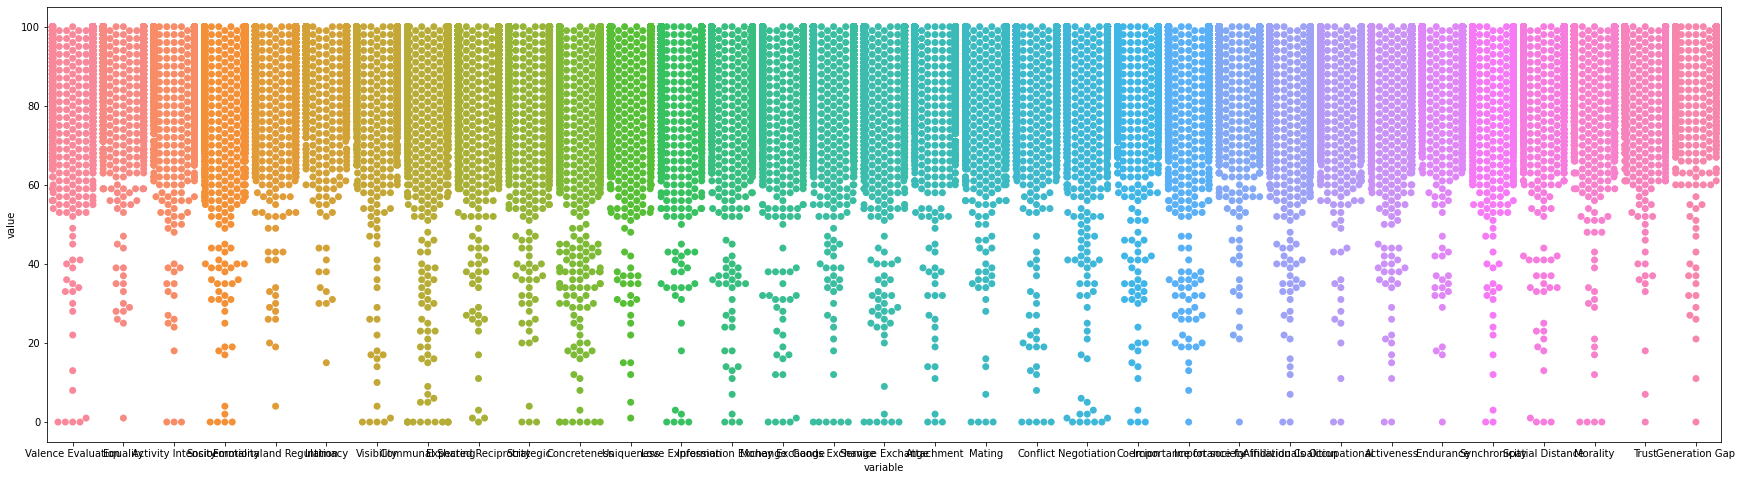

In [90]:
dim_com_df_melt = pd.melt(dim_com_df_change)
dim_com_df_melt = dim_com_df_melt.dropna()
dim_com_df_melt['value'] = dim_com_df_melt['value'].apply(pd.to_numeric)

plt.figure(figsize=(30,8))
sns.swarmplot(data=dim_com_df_melt,x='variable',y='value',size=7)

# Filter and form dictionary

Standard:   
judge color and size: 3.5 std  
judge relationships: 2 std    
familiarity: 3.5 std  

In [82]:
# Check color foils to exclude people
foil_items = [x for x in raw.columns.tolist() if x.startswith('Q2.1')]
foil_items = foil_items + [x for x in raw.columns.tolist() if x.startswith('Q40.1')]
foil_items = raw[foil_items].iloc[0]
foil_items = [s.replace('\xe2\x80\x93', '-') for s in foil_items]
foil_items = [i.split(' - ', 1)[1] for i in foil_items]
filtered_cols = [col for col in raw_reorg if col.startswith(('Q2.1','Q40.1'))]
foils_color_size = pd.DataFrame(responses[filtered_cols])
foils_color_size.columns = foil_items
foils_color_size['SubID']  =raw_reorg['SubID']
foils_color_size = foils_color_size.apply(pd.to_numeric)
foils_color_size_melt = pd.melt(foils_color_size, id_vars='SubID')


# Check for values above means for unexpected foils
outliers_color_size_list = []
for col in foils_color_size.columns[:-1]:
    outliers_color_size_list = outliers_color_size_list + list(foils_color_size[(foils_color_size[col] > 
                   foils_color_size[col].mean()+foils_color_size[col].std()*3.5) |
                   (foils_color_size[col] < 
                    foils_color_size[col].mean()-foils_color_size[col].std()*3.5)].index)
outliers_color_size_list = set(outliers_color_size_list)


# Remove outliers based on assumptions of words
foil_color_size_outliers = foils_color_size
foil_color_size_outliers = foil_color_size_outliers[~foil_color_size_outliers.index.isin(outliers_color_size_list)]
foil_color_size_outliers_melt = pd.melt(foil_color_size_outliers, id_vars='SubID')

# Check foils to see if any subjs responded indiscriminately
foil_relationships = [x for x in raw.iloc[0].tolist() if x.startswith('Q39')]
foil_relationships = [x[6:] for x in foil_relationships]
foil_relationships = [x for x in raw.columns.tolist() if x.startswith('Q39.1')]
foil_relationships = raw[foil_relationships].iloc[0]
foil_relationships = [s.replace('\xe2\x80\x93', '-') for s in foil_relationships]
foil_relationships = [i.split(' - ', 1)[1] for i in foil_relationships]
filtered_cols = [col for col in raw_reorg if col.startswith('Q39.1')]
foils = pd.DataFrame(responses[filtered_cols])
foils.columns = foil_relationships
foils['SubID']  =raw_reorg['SubID']
foils = foils.apply(pd.to_numeric)
foils_melt = pd.melt(foils, id_vars='SubID')


# Check for values above means for unexpected foils
outliers_list = []
for rel in foils.columns[:-1]:
    outliers_list = outliers_list + list(foils[(foils[rel] > 
                   foils[rel].mean()+foils[rel].std()*2) |
                   (foils[rel] < 
                    foils[rel].mean()-foils[rel].std()*2)].index)
outliers_list = set(outliers_list)


# Remove outliers based on assumptions of words
foil_outliers = foils
foil_outliers = foil_outliers[~foil_outliers.index.isin(outliers_list)]
foil_outliers_melt = pd.melt(foil_outliers, id_vars='SubID')

# Remove relationship ratings where subjects indicated that they did not 
# understand the relationships
filtered_cols = [col for col in raw_reorg if col.startswith(('Q3.1'))]
familiarity = pd.DataFrame(raw_reorg[filtered_cols])
familiarity.columns = relationships
familiarity['SubID'] = raw_reorg['SubID']
familiarity = familiarity.apply(pd.to_numeric)
familiarity_melt = pd.melt(familiarity, id_vars='SubID')


# Check for values above means for unexpected foils
familiarity_list = []
for col in familiarity.columns[:-1]:
    familiarity_list = familiarity_list + list(familiarity[(familiarity[col] < 
                    familiarity[col].mean()-familiarity[col].std()*3.5)].index)
familiarity_list = set(familiarity_list)

# Remove outliers from the rest of the data
outliers_all_list = set(list(outliers_list) + list(outliers_color_size_list) + list(familiarity_list))
outliers_all_list_df = pd.DataFrame(outliers_all_list)
outliers_all_list_df.to_csv('../output_data/outlier_df/CHN.csv')

dimension_frames_outliers = dimension_frames.copy()
for dim in dimensions:
    dimension_frames_outliers[dim] = dimension_frames[dim][~dimension_frames[dim].index.isin(outliers_all_list)]
    dimension_frames_outliers[dim] = dimension_frames_outliers[dim].apply(pd.to_numeric)
     
# Check total number of responses for each word with outliers excluded
num_response_outliers = pd.DataFrame(index=relationships,columns=dimensions)
for dim in dimensions:
    num_response_outliers[dim] = dimension_frames_outliers[dim].count() 

print("Total number of responses, excluding bad participants - "+str(len(dimension_frames_outliers[dim])))
print("Smallest number of ratings for a relationship - " + str(min(list(num_response_outliers.min()))))
print("Largest number of ratings for a relationship - " + str(max(list(num_response_outliers.max()))))

Total number of responses, excluding bad participants - 4751
Smallest number of ratings for a relationship - 15
Largest number of ratings for a relationship - 53


# Demographic

In [83]:
outlier_df = pd.read_csv('../output_data/outlier_df/CHN.csv',index_col=0)
outlier_df_list = outlier_df.iloc[:,0].to_list()
foils_color_size_outliers = foils_color_size[~foils_color_size.index.isin(outlier_df_list)]
foils_color_size_outliers.to_csv('../output_data/foils_rel_size/CHN.csv')
familiarity_outliers = familiarity[~familiarity.index.isin(outlier_df_list)]
familiarity_outliers.to_csv('../output_data/familiarity/CHN.csv')

# Demographics
demo_orig = pd.read_csv(qual_output, header=1, 
                        usecols=range(len(raw_reorg.iloc[0])-9,
                                      len(raw_reorg.iloc[0])-1))
demo_orig = demo_orig.drop(axis='index',index=0)
demo_orig = demo_orig.reset_index(drop=True)
demographics = demo_orig
response_demographic = demo_orig[~demo_orig.index.isin(list(outlier_df_list))]

In [89]:
dim_com_df = dim_com_df_change.reset_index(drop=True)
dim_com_df_outliers = dim_com_df[~dim_com_df.index.isin(outlier_df_list)]
dim_com_df_outliers.to_csv('../output_data/dimension_comprehension/CHN.csv')

## Gender

In [9]:
response_demographic['Sex'].value_counts()

female    2661
male      2090
Name: Sex, dtype: int64

## Age

In [10]:
response_demographic['Age'].value_counts()

25 - 34    2073
18 - 24    2025
35 - 44     477
45 - 54     105
55 - 64      39
18以下         28
65 - 74       4
Name: Age, dtype: int64

## Race

In [11]:
response_demographic['Race'].value_counts()

汉族    4626
其他     125
Name: Race, dtype: int64

## Highest education

In [12]:
response_demographic['Highest Level of Education'].value_counts()

bachelor             3385
master                597
college               489
high school           156
phd or post doc        52
below high school      42
phd and post doc       30
Name: Highest Level of Education, dtype: int64

## First language

In [13]:
response_demographic['请问中文是您的母语吗？'].value_counts()

是    4744
否       7
Name: 请问中文是您的母语吗？, dtype: int64

In [13]:
response_demographic = response_demographic.iloc[:,:-1]
response_demographic['Gender_label'] = response_demographic['Sex']
response_demographic.to_csv('../output_data/demographic/CHN.csv')

# Heatmap

In [14]:
relationships_trans_258 = pd.read_csv('../input_data/Nations/CHN/NLP/Total_Relation_6_trans.csv', 
                                  header=None).iloc[:,0].tolist()
relationships = NLP_to_Trans(relationships_trans_258)
relationships_159 = pd.read_csv('../input_data/RelDim_labels/159relationships_fix_label.csv',index_col=0)
relationships_159 = relationships_159.iloc[:,0].to_list()

dimensions = key['dimension'].tolist()[2:-3]
dimensions = [i.replace('Importance for individuals involved','Importance for individuals') for i in dimensions]
dimensions = [i.replace('/','_') for i in dimensions]
dimensions_33d = [i for i in dimensions if i not in ['Kinship','Legality']]

In [15]:
dimension_frames_159r_33d = {}
for dim in dimensions_33d:
    dimension_frames_159r_33d[dim] = dimension_frames_outliers[dim].loc[:,relationships_159]
    dimension_frames_159r_33d[dim] = dimension_frames_159r_33d[dim].apply(pd.to_numeric)
    
all_ids = dimension_frames_159r_33d[dim].index.to_list()
left_ids = []
for dim in dimensions_33d:
    temp_df = dimension_frames_159r_33d[dim].copy()
    temp_df.dropna(how='all',inplace=True)
    left_id = temp_df.index.to_list()
    [left_ids.append(i) for i in left_id]
left_ids = list(set(left_ids))

dimension_frames_159r_33d_outliers = dimension_frames_159r_33d.copy()
for dim in dimensions_33d:
    dimension_frames_159r_33d_outliers[dim] = dimension_frames_159r_33d_outliers[dim].loc[left_ids,:]
    dimension_frames_159r_33d_outliers[dim] = dimension_frames_159r_33d_outliers[dim].apply(pd.to_numeric)

In [17]:
dimensions_dict = dimensions_33d
dimensions_dict = [i.replace('Moral','Morality') for i in dimensions_dict]
dimensions_dict = [i.replace('Accountable','Trust') for i in dimensions_dict]

In [20]:
with pd.ExcelWriter('../dict_results/CHN.xlsx') as writer:
    for dim in dimension_frames_159r_33d.keys():
        rel_sub_df = dimension_frames_159r_33d[dim]
        if dim == 'Moral':
            dim = 'Morality'
        elif dim == 'Accountable':
            dim = 'Trust'
        rel_sub_df.to_excel(writer,sheet_name = dim)

In [17]:
dim_rel_NLP_33d_r10 = pd.DataFrame(np.nan, columns=relationships_159, index=dimensions_33d)
for dim in dimensions_33d:
    mean_temp_sub = []
    for rel in relationships_159:
        cell_allsample = dimension_frames_outliers[dim][rel].dropna()
        cell_subsample = cell_allsample.sample(n=10, random_state=3)
        
        mean_temp_sub.append(cell_subsample.mean())
    dim_rel_NLP_33d_r10.loc[dim,:] = mean_temp_sub 

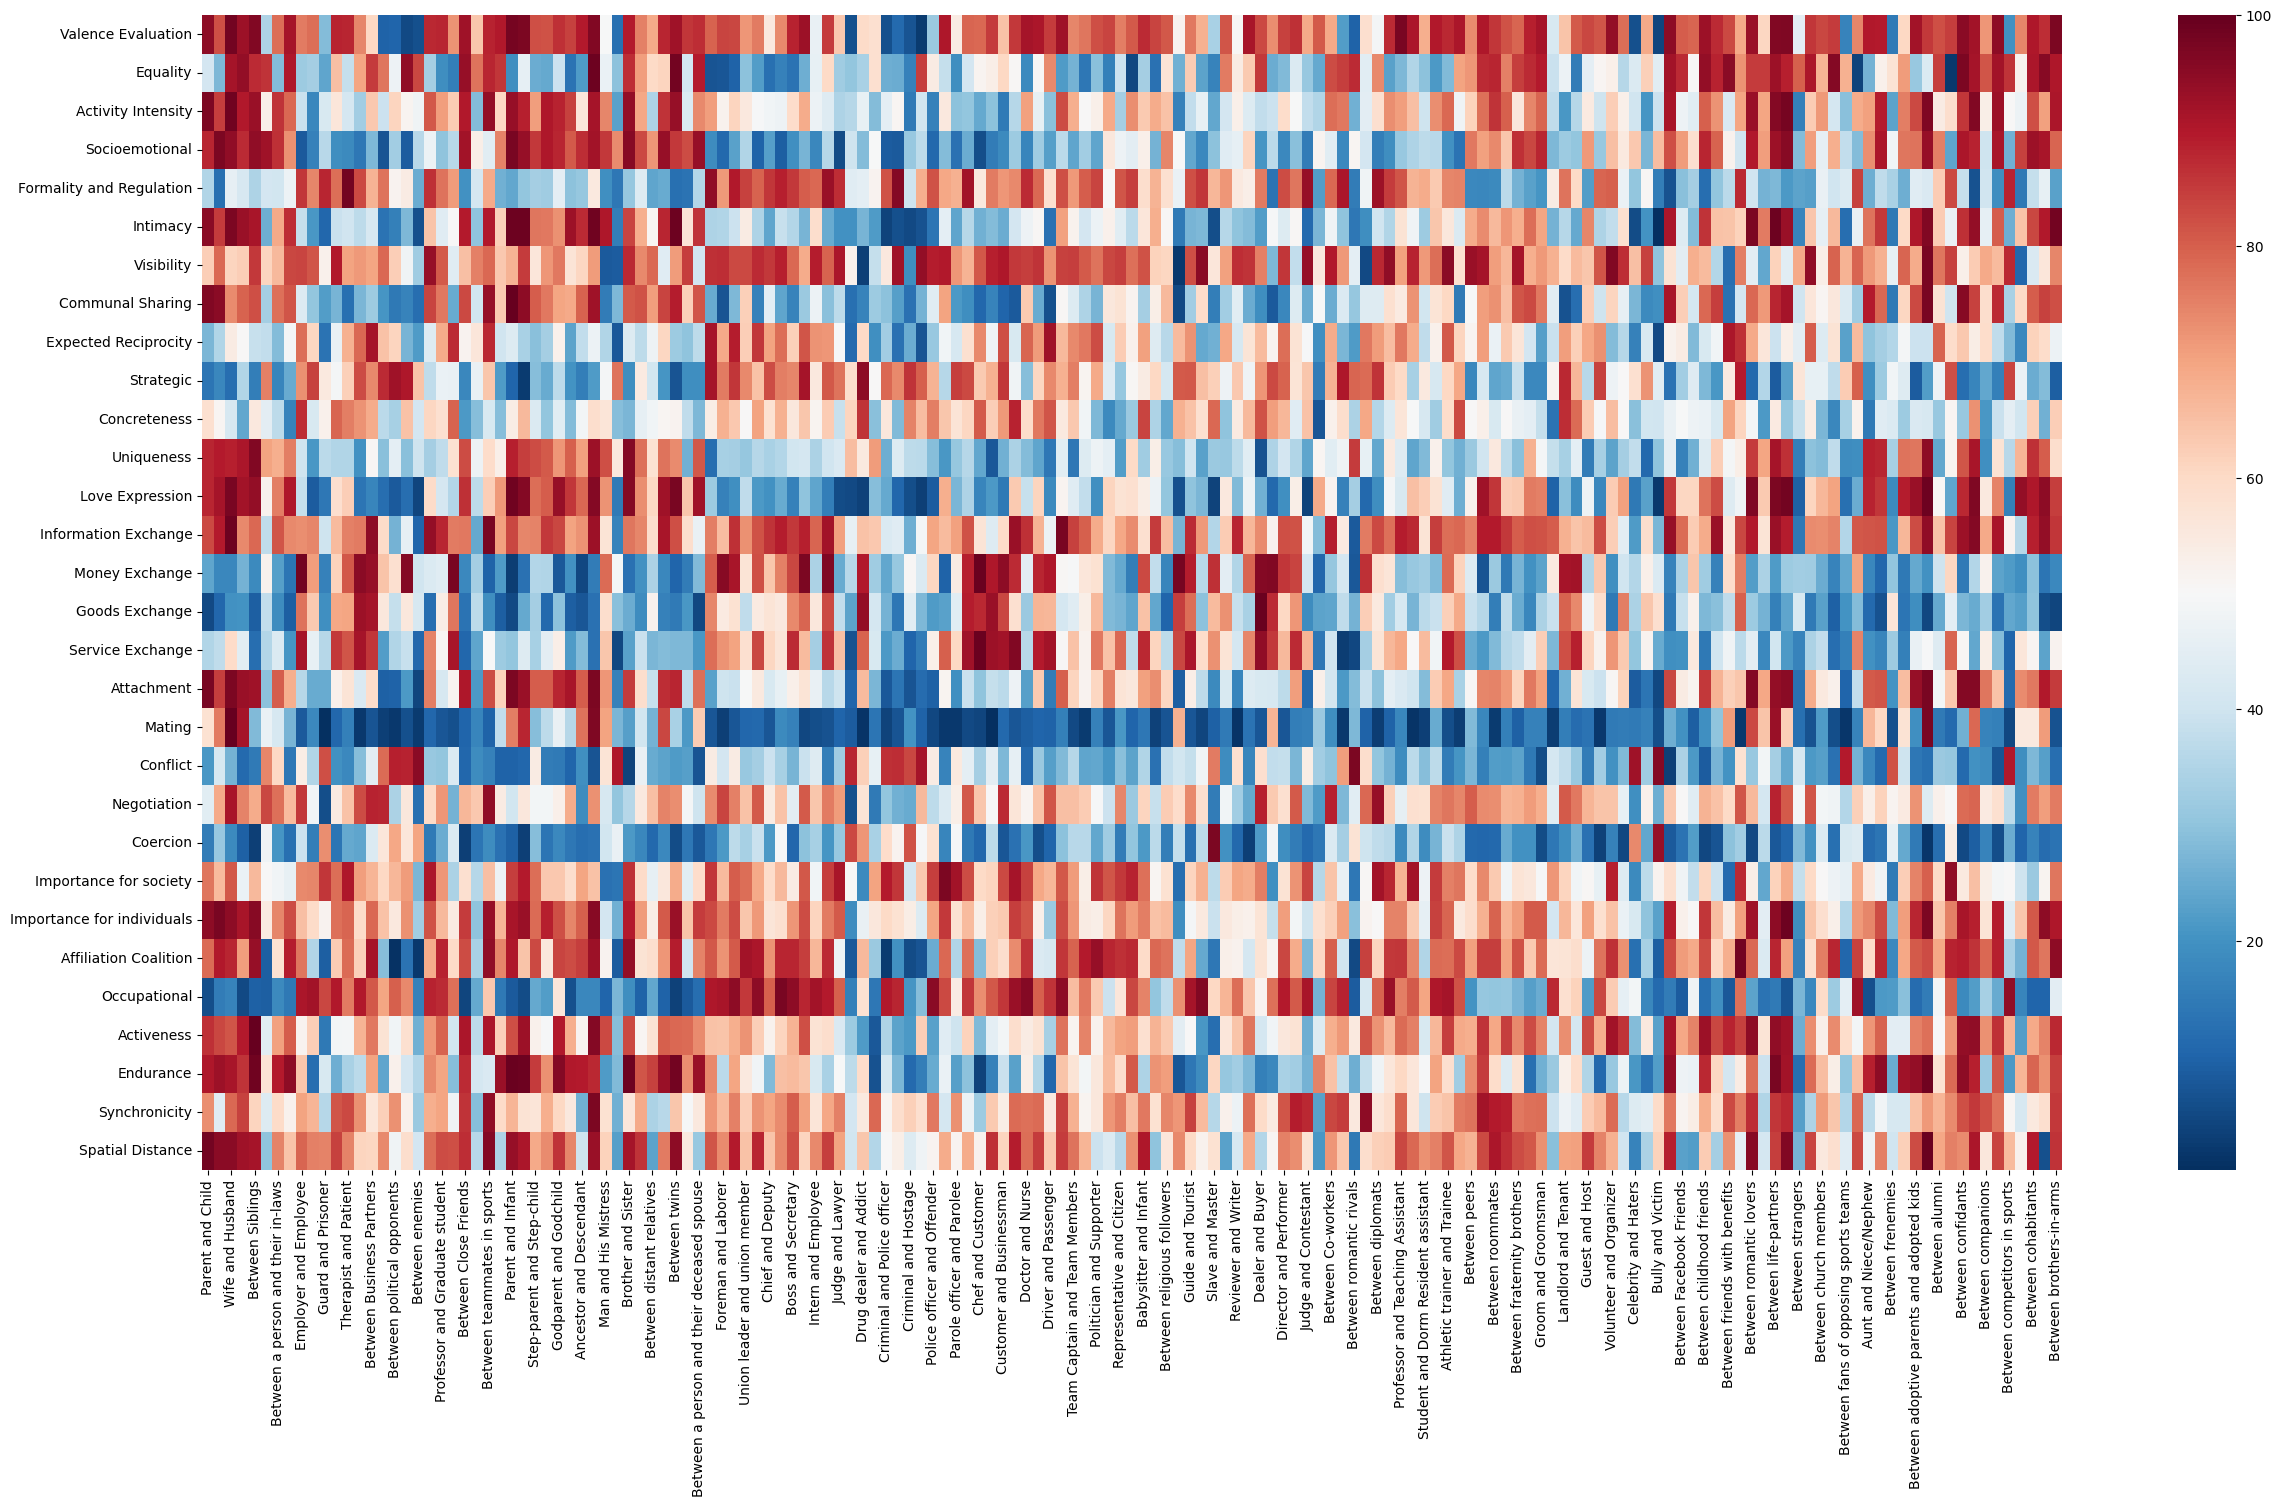

In [18]:
dimensions_33d = [i.replace('Moral','Morality') for i in dimensions_33d]
dimensions_33d = [i.replace('Accountable','Trust') for i in dimensions_33d]
dim_rel_NLP_33d_r10.index = dimensions_33d

dim_rel = dim_rel_NLP_33d_r10
dim_rel.to_csv('../output_data/cleaning_results/CHN/CHN_dim_rel.csv')
dim_rel_scaled = preprocessing.scale(dim_rel.transpose())
dim_rel_scaled_df = pd.DataFrame(dim_rel_scaled, index=dim_rel.columns,
                                 columns=dim_rel.index)
dim_rel_scaled_df.to_csv('../output_data/cleaning_results/CHN/CHN_dim_rel_scaled.csv')

## Filter 159*30
dim_rel_30d = dim_rel.iloc[:30]
plt.figure(figsize=(30,15))
heatmap = sns.heatmap(dim_rel_30d, center=50,cmap="RdBu_r")
dim_rel_30d.to_csv('../output_data/cleaning_results/CHN/CHN_dim_rel_30d.csv')
dim_rel_scaled_30d_df = dim_rel_scaled_df.iloc[:,:30]
dim_rel_scaled_30d_df.to_csv('../output_data/cleaning_results/CHN/CHN_dim_rel_scaled_30d.csv')

# PCA with varimax rotation

In [3]:
library(tidyverse)
library(reshape)

library(psych)
#optimal number of components
library(nFactors)

library(ggplot2)
library(pheatmap)
library(RColorBrewer)
library(corrplot)

In [4]:
plotnScree <-
function (nScree,
          elbow = 3,
          legend = TRUE,
          ylab   = "Eigenvalues",
          xlab   = "Components",
          main   = "Non Graphical Solutions to Scree Test")
          {
   if (!inherits(nScree, "nScree"))  stop("Method is only for nScree objects")
   #if (!exists("legend", mode="logical") ) legend <- TRUE                                   # To develop
   #if (!exists("ylab"))                    ylab <- "Eigenvalues"                            # To develop
   #if (!exists("xlab"))                    xlab <- "Components"                             # To develop
   #if (!exists("main"))                    main <- "Non Graphical Solutions to Scree Test"  # To develop
   if (nScree$Model == "components") nkaiser = "Eigenvalues (>mean  = " else nkaiser = "Eigenvalues (>0 = "
   if (nScree$Model == "factors")  xlab   = "Factors"
   par(col   = 1, pch = 1)     # Color and symbol for usual scree
   par(mfrow = c(1,1),lwd=2)
   eig        <- nScree$Analysis$Eigenvalues
   k          <- 1:length(eig)
   #plotuScree(x=eig, ...)                                                                   # To develop
   plotuScree(x=eig, main=main, xlab=xlab, ylab=ylab)
   nk         <- length(eig)
   noc        <- nScree$Components$noc
   vp.p       <- lm(eig[c(noc+1,nk)] ~ k[c(noc+1,nk)])
   x          <- sum(c(1,1) * coef(vp.p))
   y          <- sum(c(1,nk)* coef(vp.p))
   par(col = 10)            # Color for optimal coordinates
   lines(k[c(1,nk)],c(x,y),lwd=1.8)
   par(col = 11,pch=2)            # Color and symbol for parallel analysis
   lines(1:nk, nScree$Analysis$Par.Analysis, type = "b",lwd=1.8)
   if (legend == TRUE) {
     leg.txt  <- c(paste("Parallel Analysis (n = ",nScree$Components$nparallel,")"),
                 c(paste("Kaiser-Guttman rule (n = ",nScree$Components$nkaiser,")")),
                 c(paste("Cattell’s scree test (n = ",elbow,")")),
                 c(paste("Optimal Coordinates (n = ",nScree$Components$noc,")")) )
     legend("topright",
            legend   = leg.txt,
            pch      = c('△','_','○','_'),
            text.col = c(3,4,1,2), 
            col = c(3,4,1,2),
            cex = 1.3)
     }
   naf        <-   nScree$Components$naf
   text(x = noc ,    y = eig[noc],     label = " (OC)", cex = 1, adj = c(0,0), col = 2)
#    text(x = naf + 1, y = eig[naf + 1], label = " (AF)", cex = .70, adj = c(0,0), col = 4)
   }

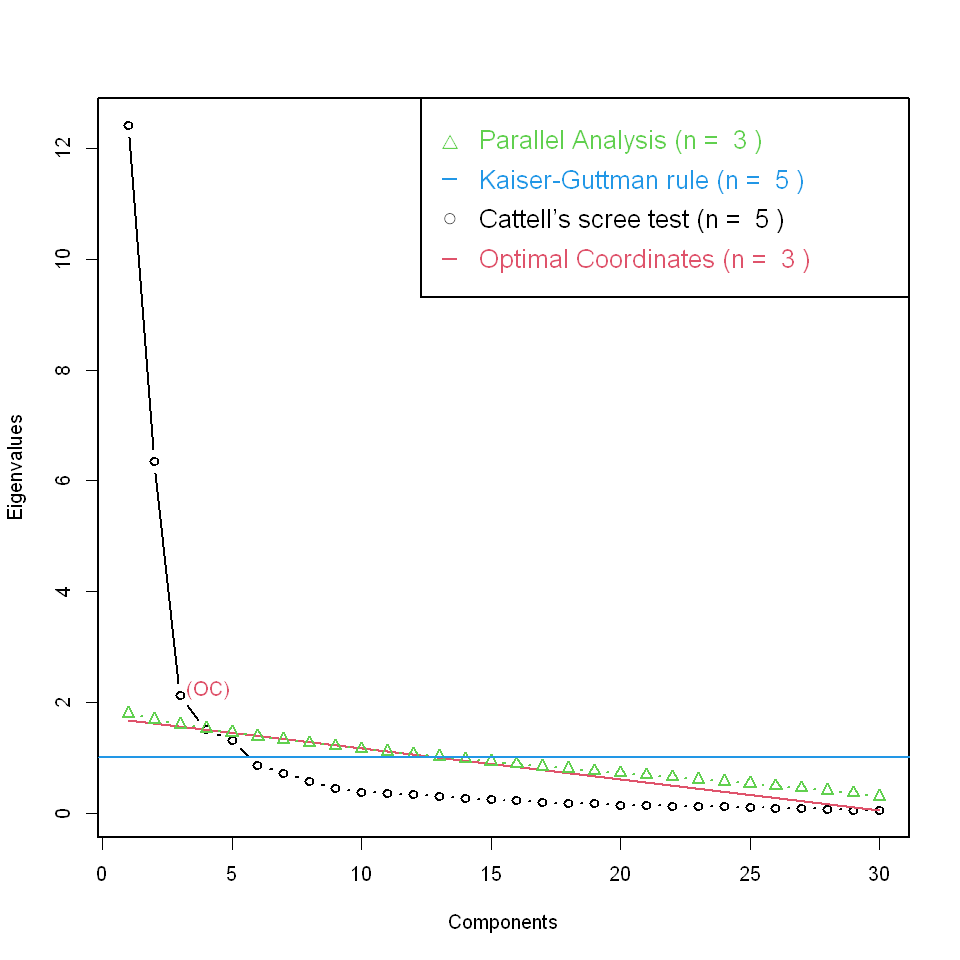

In [4]:
# import relationship dimension ratings scaled from the Data cleaning's output
dim_rel_scaled = read.csv('../output_data/cleaning_results/CHN/CHN_dim_rel_scaled_30d.csv', 
                          row.names=1,encoding='UTF-8',check.names=FALSE)

options(repr.plot.width=8, repr.plot.height=8)
# Parallel analysis, Optimal Coordinates, and  Cattell's Scree Test
ev <- eigen(cor(dim_rel_scaled)) # get eigenvalues
ap <- parallel(subject=nrow(dim_rel_scaled),var=ncol(dim_rel_scaled),model="components",rep=5000,cent=.05) 
nS <- nScree(x=ev$values, aparallel=ap$eigen$qevpea) # "qevpea" indicate 95 centile given cent=.05

plotnScree(nS,elbow = 5, legend=TRUE, main = NULL)
abline(h = 1, col=4, lty=1,lwd =1.8) # Kaiser-Guttman Rule

## 5d solution

In [6]:
dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 5

loadings_none = dim_rel.pca$rotation[,1:ncomp]
scores_none = dim_rel.pca$x[,1:ncomp] 

rawLoadings = loadings_none %*% diag(dim_rel.pca$sdev,ncomp,ncomp)
loadings_var = varimax(rawLoadings)$loadings
scores_var = scale(scores_none) %*% varimax(rawLoadings)$rotmat

write.csv(loadings_var,'../output_data/pca_results/CHN/CHN_loadings_var_5c_30d.csv')
scores_var = as.data.frame(scores_var)
write.csv(scores_var,'../output_data/pca_results/CHN/CHN_scores_var_5c_30d.csv')

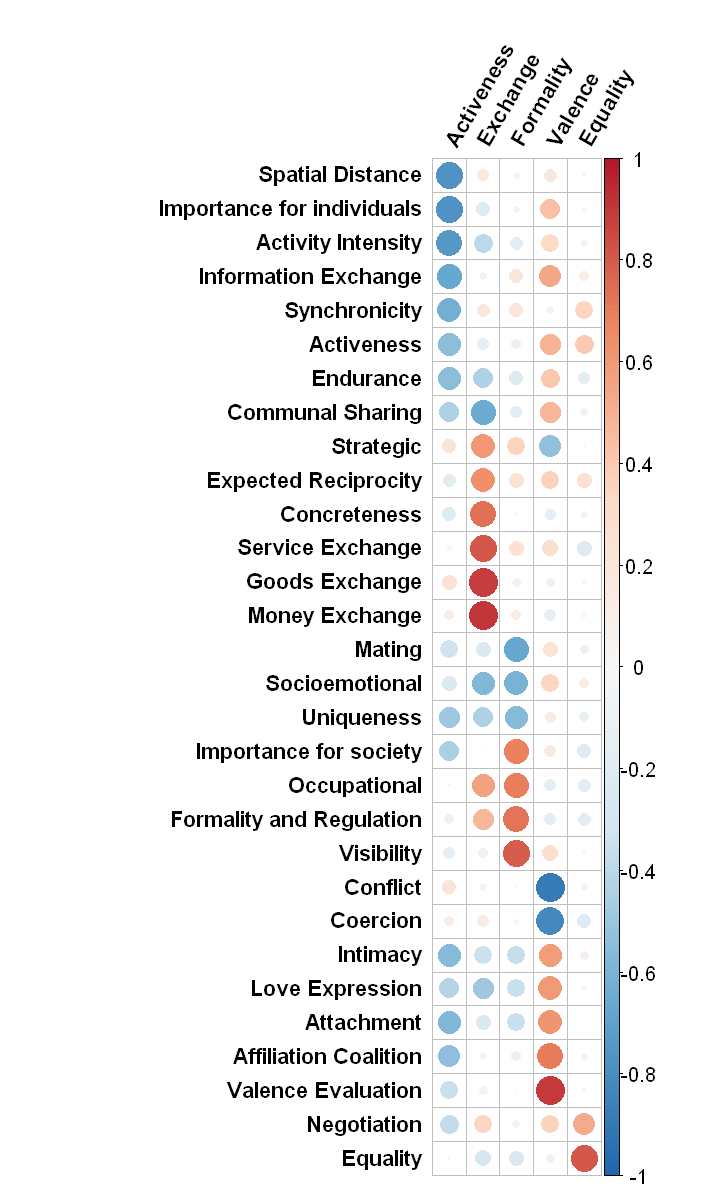

In [7]:
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:30)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:5)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
loadings_var_reorder['rel'] = rownames(loadings_var_reorder)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(V1)
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(V2)
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(V3)
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(V4)
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(V5)
rownames(loadings_var_reorder) = loadings_var_reorder$'rel'

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
loadings_var_reorder = loadings_var_reorder[1:5]

colnames(loadings_var_reorder) = c('Activeness','Exchange','Formality','Valence','Equality')
options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

Warning message:
"程辑包'ggrepel'是用R版本4.1.3 来建造的"


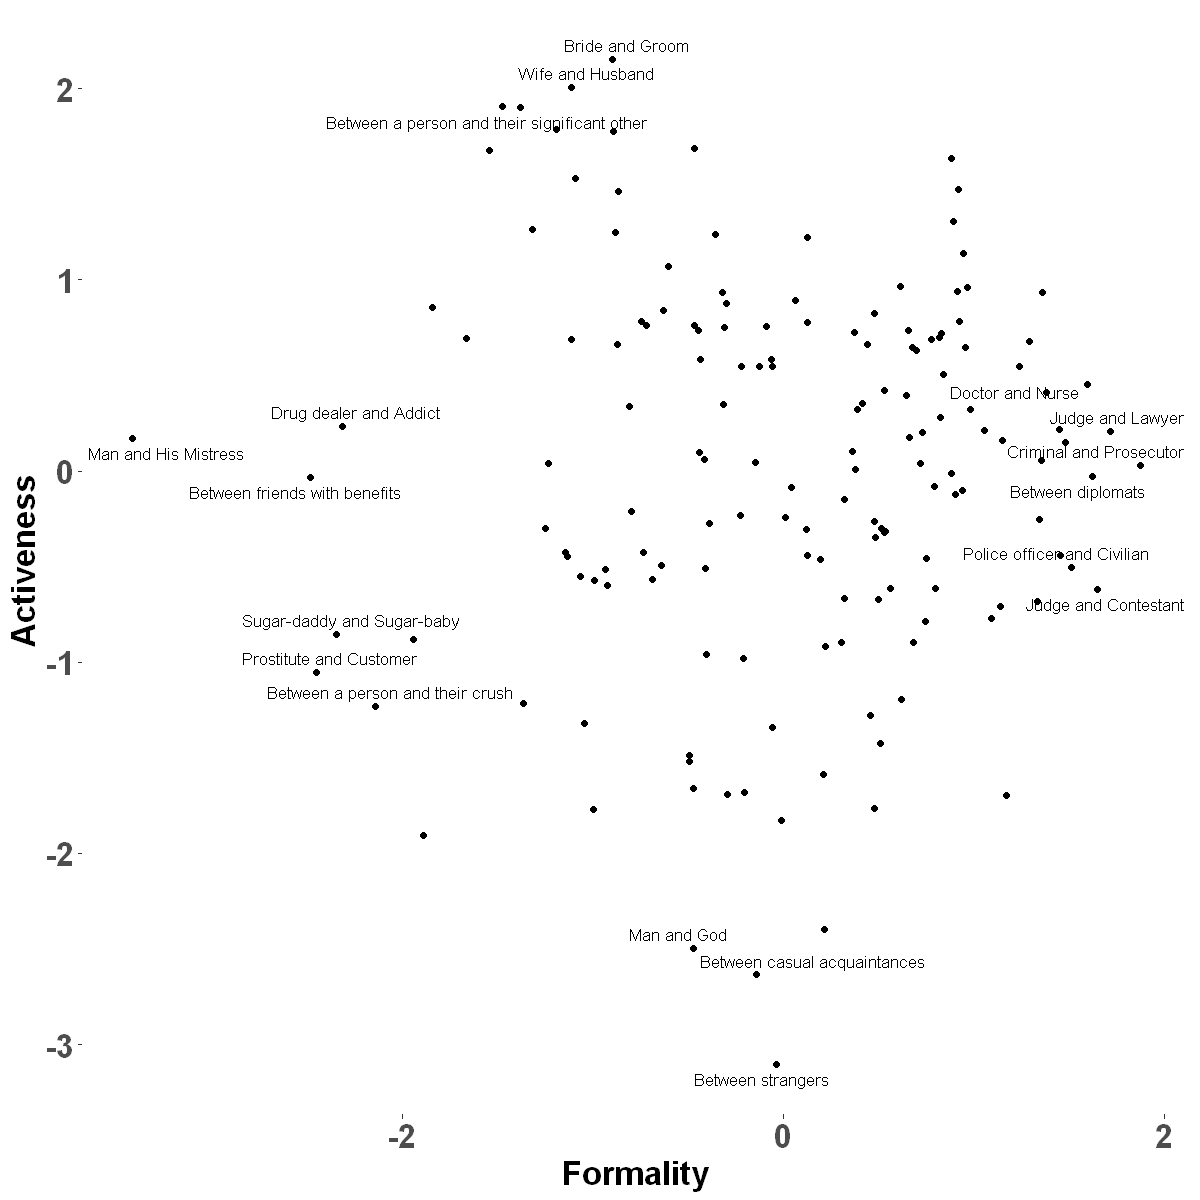

In [8]:
library(ggrepel)
num = 3
show_rel = c(rownames(scores_var[order(scores_var$V1),])[1:num],
             rownames(scores_var[order(scores_var$V1),])[159-num+1:159],
             #rownames(scores_var[order(scores_var$V2),])[1:6],
             #rownames(scores_var[order(scores_var$V2),])[159-6+1:159],
             rownames(scores_var[order(scores_var$V3),])[1:6],
             rownames(scores_var[order(scores_var$V3),])[159-6+1:159]
             #rownames(scores_var[order(scores_var$V4),])[1:num],
             #rownames(scores_var[order(scores_var$V4),])[159-num+1:159],
             #rownames(scores_var[order(scores_var$V5),])[1:6],
             #rownames(scores_var[order(scores_var$V5),])[159-6+1:159]
             )
scores_var_plot = scores_var
colnames(scores_var_plot) = c('Activeness','Exchange','Formality','Valence','Equality')
scores_var_plot['Activeness'] = -scores_var_plot['Activeness']

scores_var_plot['rel'] = rownames(scores_var_plot)
show_rel_df = scores_var_plot %>% filter(rel %in% show_rel)

options(repr.plot.width=10,repr.plot.height=10)
ggplot(scores_var_plot,aes(x=Formality,y=Activeness))+
geom_point()+
geom_text_repel(data=show_rel_df,aes(label=rel),size=3.5)+
#scale_size_continuous(range = c(3,6.5))+
theme_bw()+
theme(panel.border=element_blank(),panel.grid=element_blank(),
      legend.title=element_text(face="bold",size=20),
      axis.title.x=element_text(size=20,face='bold'),
      axis.title.y=element_text(size=20,face='bold'),
      axis.text=element_text(size=20,face='bold'),
      legend.position='top',
      legend.text=element_text(face="bold",size=20))

# ggplot(scores_var_plot,aes(x=Formality,y=Visibility))+
# geom_point()+
# geom_text_repel(data=show_rel_df,aes(label=rel),size=3.5)+
# #scale_size_continuous(range = c(3,6.5))+
# theme_bw()+
# theme(panel.border=element_blank(),panel.grid=element_blank(),
#       legend.title=element_text(face="bold",size=20),
#       axis.title.x=element_text(size=20,face='bold'),
#       axis.title.y=element_text(size=20,face='bold'),
#       axis.text=element_text(size=20,face='bold'),
#       legend.position='top',
#       legend.text=element_text(face="bold",size=20))

## 33d

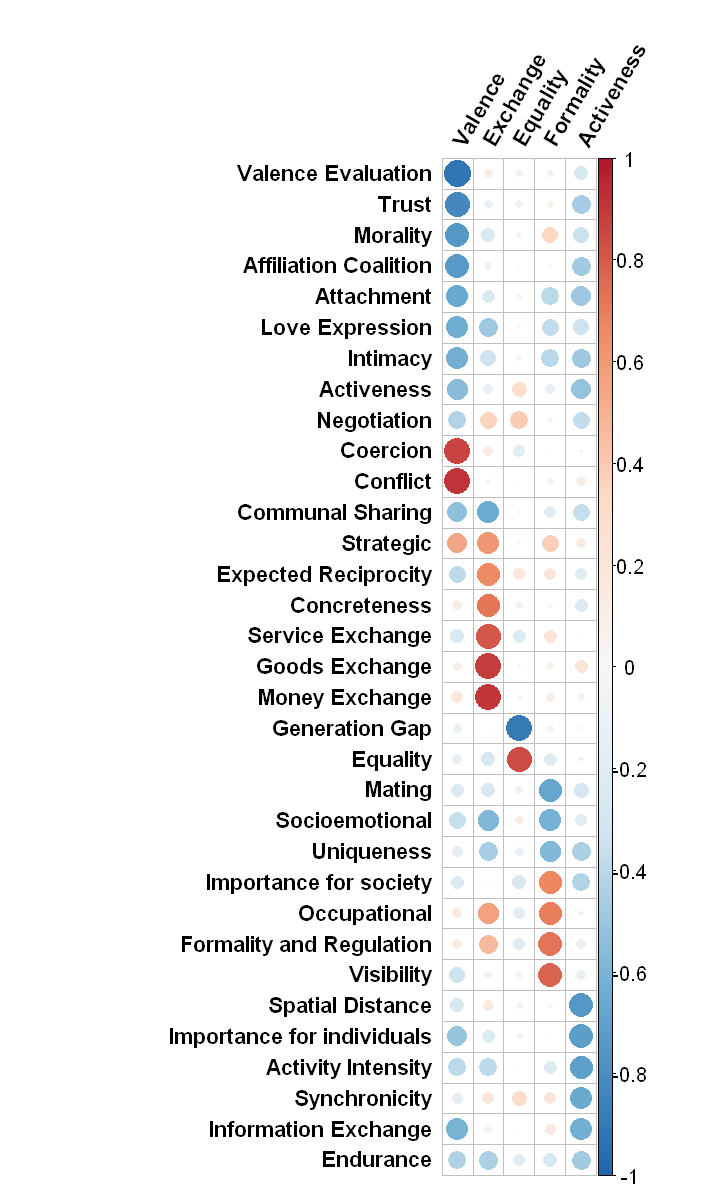

In [5]:
dim_rel_scaled_33d = read.csv('../output_data/cleaning_results/CHN/CHN_dim_rel_scaled.csv',
                          row.names=1,encoding='UTF-8',check.names=FALSE)

dim_rel.pca = prcomp(dim_rel_scaled_33d)
ncomp = 5

loadings_none = dim_rel.pca$rotation[,1:ncomp]
scores_none = dim_rel.pca$x[,1:ncomp] 

rawLoadings = loadings_none %*% diag(dim_rel.pca$sdev,ncomp,ncomp)
loadings_var = varimax(rawLoadings)$loadings
scores_var = scale(scores_none) %*% varimax(rawLoadings)$rotmat

write.csv(loadings_var,'../output_data/pca_results/CHN/CHN_loadings_var_5c_33d.csv')
scores_var = as.data.frame(scores_var)
write.csv(scores_var,'../output_data/pca_results/CHN/CHN_scores_var_5c_33d.csv')

#####################################################################################
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:5)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
loadings_var_reorder['rel'] = rownames(loadings_var_reorder)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(V1)
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(V2)
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(V3)
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(V4)
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(V5)
rownames(loadings_var_reorder) = loadings_var_reorder$'rel'

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
loadings_var_reorder = loadings_var_reorder[1:5]

colnames(loadings_var_reorder) = c('Valence','Exchange','Equality','Formality','Activeness')
options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

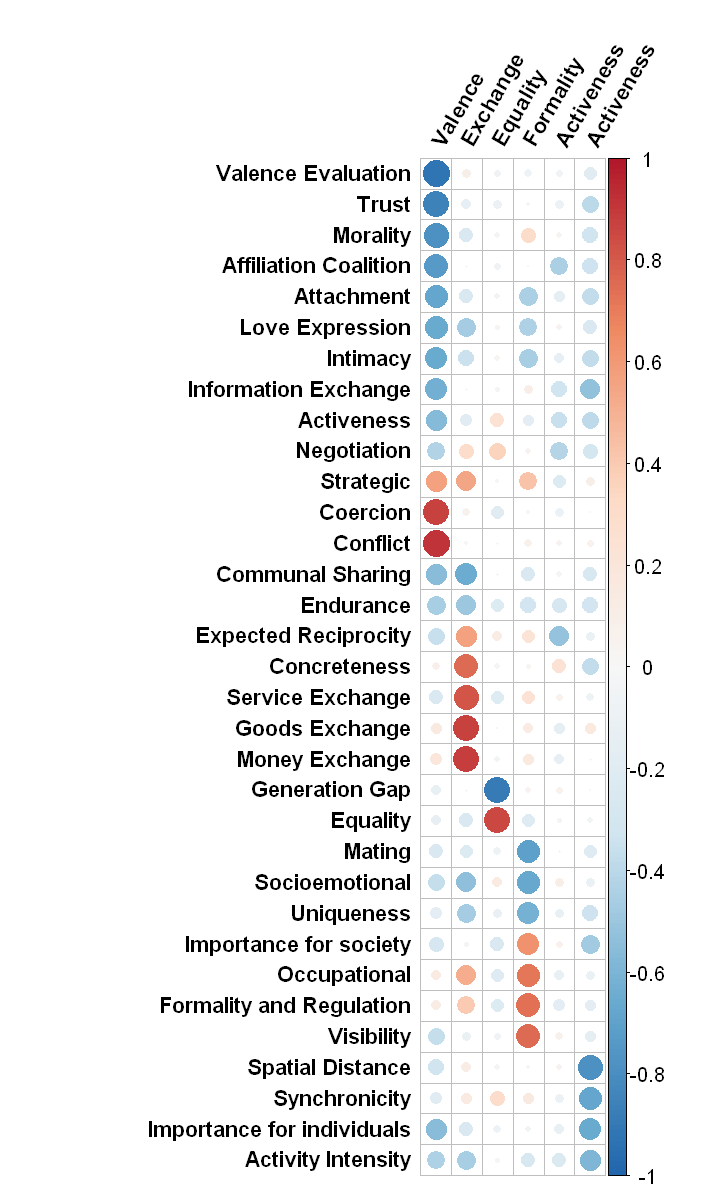

In [7]:
dim_rel_scaled_33d = read.csv('../output_data/cleaning_results/CHN/CHN_dim_rel_scaled.csv',
                          row.names=1,encoding='UTF-8',check.names=FALSE)

dim_rel.pca = prcomp(dim_rel_scaled_33d)
ncomp = 6

loadings_none = dim_rel.pca$rotation[,1:ncomp]
scores_none = dim_rel.pca$x[,1:ncomp] 

rawLoadings = loadings_none %*% diag(dim_rel.pca$sdev,ncomp,ncomp)
loadings_var = varimax(rawLoadings)$loadings
scores_var = scale(scores_none) %*% varimax(rawLoadings)$rotmat

# write.csv(loadings_var,'../output_data/pca_results/CHN/CHN_loadings_var_5c_33d.csv')
# scores_var = as.data.frame(scores_var)
# write.csv(scores_var,'../output_data/pca_results/CHN/CHN_scores_var_5c_33d.csv')

#####################################################################################
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:6)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
loadings_var_reorder['rel'] = rownames(loadings_var_reorder)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(V1)
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(V2)
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(V3)
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(V4)
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(V5)
RC6 = loadings_var_reorder %>% filter(order==6) %>% arrange(V6)
rownames(loadings_var_reorder) = loadings_var_reorder$'rel'

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5,RC6)
loadings_var_reorder = loadings_var_reorder[1:6]

colnames(loadings_var_reorder) = c('Valence','Exchange','Equality','Formality',
                                   'Activeness','Activeness')
options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))